In [104]:
import QDYN
import matplotlib.gridspec as gridspec
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
from collections import OrderedDict
from glob import glob
from os.path import join

In [105]:
def monotonic_convergence(iter, J_T):
    iter_out = []
    J_T_out = []
    J_T_prev = None
    for iter_val, J_T_val in zip(iter, J_T):
        if J_T_prev is not None:
            if J_T_prev < J_T_val:
                continue # drop
        iter_out.append(iter_val)
        J_T_out.append(J_T_val)
        J_T_prev = J_T_val
    return iter_out, J_T_out

In [3]:
def plot_convergence_comparison(runfolders, monotonic=False, xlim=None):
    conv = QDYN.octutils.OCTConvergences()
    for rf in runfolders:
        conv.load_file(
            rf.split('/')[-1],
            join(rf, 'oct_iters.dat'))
    fig, ax = plt.subplots(figsize=(10, 6))
    for (key, data) in conv.data.items():
        if monotonic:
            ax.plot(*monotonic_convergence(data.iter, data.J_T), label=key)
        else:
            ax.plot(data.iter, data.J_T, label=key)
    ax.legend()
    ax.set_yscale('log')
    ax.set_xlabel("iteration")
    ax.set_ylabel("error")
    if xlim is not None:
        ax.set_xlim(xlim)
    plt.show(fig)

In [4]:
def rf_sort_key(rf):
    """Key for sorting runfolder according to number of trajectories"""
    try:
        a, b = rf.split('_ntrajs')
        return (a, int(b))
    except ValueError:
        return (rf, 0)

In [5]:
def plot_rho_prop_error_comparison(runfolders, xlim=None):
    fig, ax = plt.subplots(figsize=(10, 6))
    for rf in runfolders:
        key = rf.split('/')[-1]
        oct_iter, err = np.genfromtxt(
            join(rf, 'rho_prop_error.dat'), unpack=True)
        ax.plot(oct_iter, err, label=key)
    ax.legend()
    ax.set_yscale('log')
    ax.set_xlabel("iteration")
    ax.set_ylabel("error")
    if xlim is not None:
        ax.set_xlim(xlim)
    plt.show(fig)

## How does convergence compare between density matrix optimization and independent-trajectory optimization?

the following compares the *optimization* J_T. Values for density matrix and trajectory optimization are not directly comparable

In [6]:
ROOT = './data/method_comparison_dicke/'

In [7]:
rfs_independent_trajs =  sorted(
    glob(join(ROOT, 'T5_independent_ntrajs*')), key=rf_sort_key)

In [8]:
rf_rho = join(ROOT, 'T5_rho_ntrajs1')

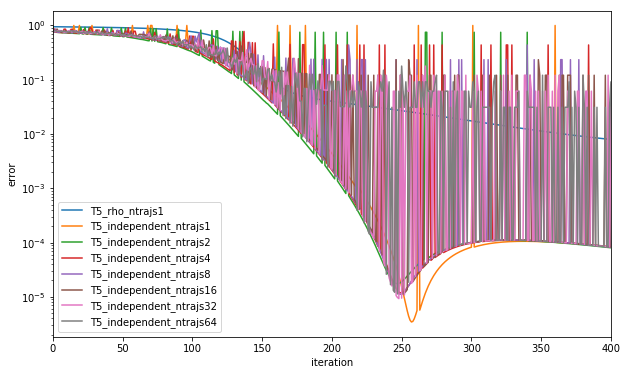

In [9]:
plot_convergence_comparison(
    [rf_rho, ] + rfs_independent_trajs, monotonic=False, xlim=(0, 400))

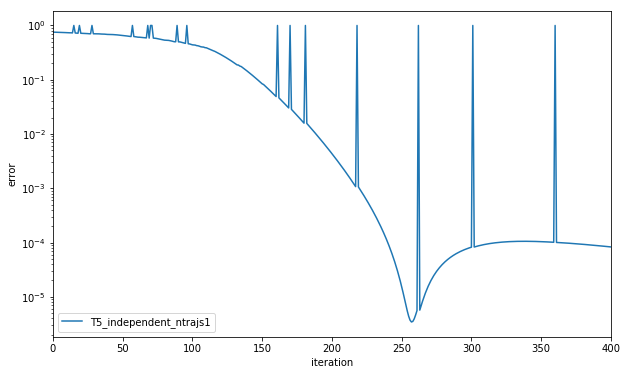

In [17]:
plot_convergence_comparison(
    rfs_independent_trajs[0:1], monotonic=False, xlim=(0, 400))

The rapid jiggling is the result of the quantum jumps: If a jump happens in a trajectory, that trajectory will contribute a zero to the fidelity. The good thing (and the non-obvious result of the paper), is while there is no monotonic convergence, there is still convergence on average, which this plot illustrates. The local minimum (e.g. at 260 for 1 traj) is because there are two competing aspects: getting to the target states (when we're lucky and there are no jumps), and minimizing dissipation (= jumps)

The same plot, but throwing out points that would violate monotonic convergence:

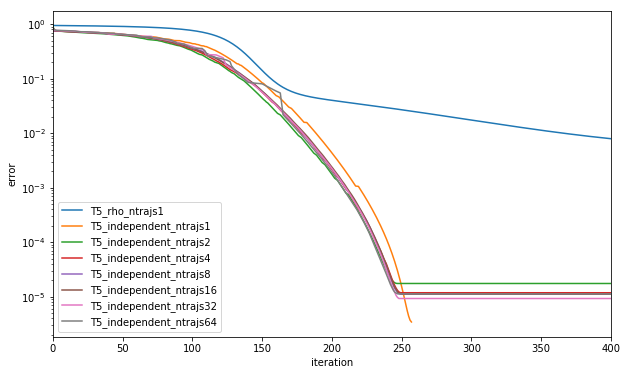

In [10]:
plot_convergence_comparison(
    [rf_rho, ] + rfs_independent_trajs, monotonic=True, xlim=(0, 400))

The following is a plot of the actual success, as $1 - <P_{target}>$, where $P_{target}$ is the projector onto the target states. This was calculated by taking the optimized pulses at each iteration, and re-running it for the full density matrix (which is easy because this is just two nodes, i.e. the Hilbert space is small). Thus, the result is exact, and it is comparable between different methods / optimization functionals, unlike the value of the optimization functional directly, shown above.

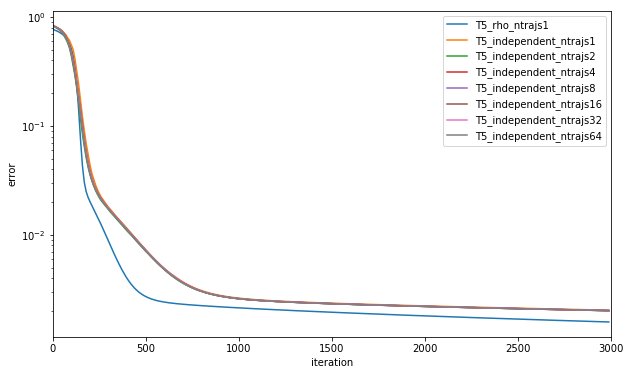

In [11]:
plot_rho_prop_error_comparison(
    [rf_rho, ] + rfs_independent_trajs, xlim=(0, 3000))

This shows that
* individual trajectories don't quite match the convergence of the full density matrix, but they get pretty close
* the number of trajectories has almost no influence on the convergence/obtained error

For the paper, it would probably be instructive to have the above figure (`In 11`), with the value for the optimization functional (`In 9`) as an inset.

## How do the pulses compare between density matrix optimization and independent-trajectory optimization?

In [12]:
from src.notebook_plots_v1 import render_pulses

In [63]:
def plot_pulse_comparison(runfolders):
    ncols = 3
    nrows = len(runfolders) // ncols
    if ncols * nrows < len(runfolders):
        nrows += 1
    fig, axs = plt.subplots(
        figsize=(16, nrows*5), ncols=ncols, nrows=nrows, squeeze=False)
    axs = axs.flatten()
    for i, rf in enumerate(runfolders):
        ax = axs[i]
        pulse1 = QDYN.pulse.Pulse.read(join(rf, 'pulse1.oct.dat'))
        pulse2 = QDYN.pulse.Pulse.read(join(rf, 'pulse2.oct.dat'))
        pulse1.render_pulse(ax, label=r'pulse 1')
        pulse2.render_pulse(ax, label=r'pulse 2')
        #pulse1.apply_smoothing().render_pulse(ax, label=r'pulse 1 (smooth)')
        #pulse2.apply_smoothing().render_pulse(ax, label=r'pulse 2 (smooth)')
        ax.legend()
        ax.set_xlabel("time")
        ax.set_ylabel("amplitude")
        ax.set_title(rf.split('/')[-1])
    plt.show(fig)

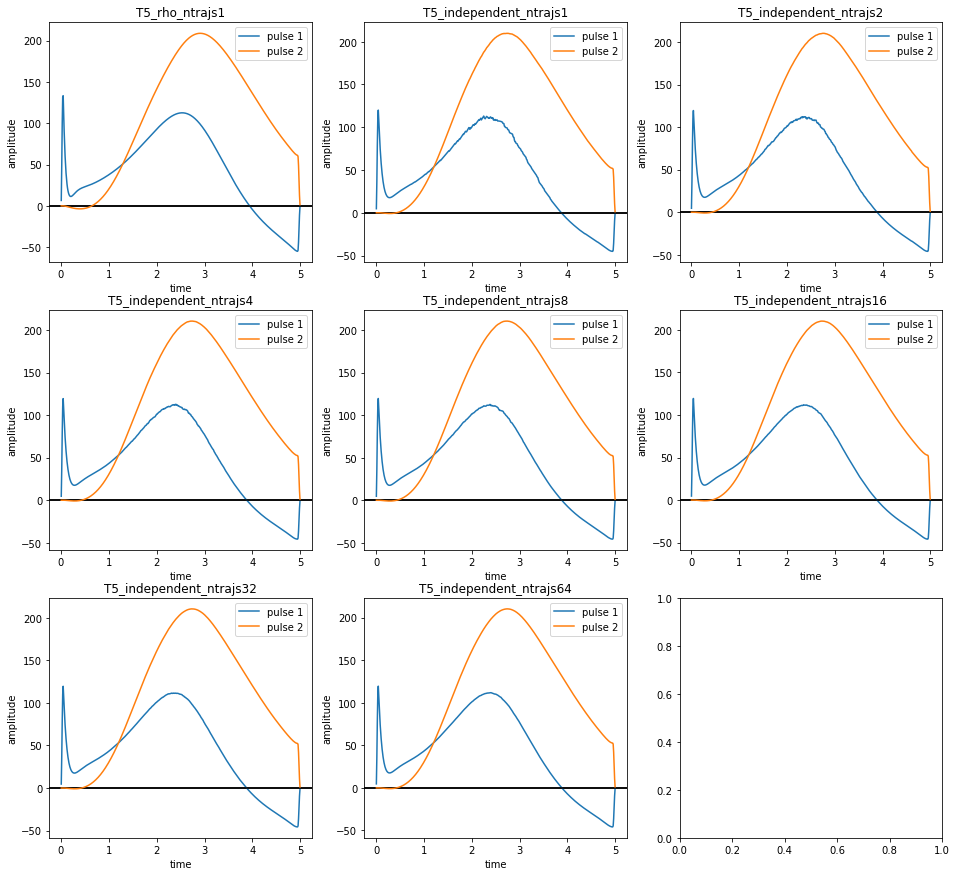

In [64]:
plot_pulse_comparison([rf_rho, ] + rfs_independent_trajs)

While the number of trajectories has negligible influence on the error, it does influence the smoothness of the pulse. The plot below tries to make the jiggles more visible, by subtracting from the optimal field obtained from density matrix optimization (reference field). Probably better to use the field for `n_traj` $\rightarrow \infty$ as a reference.

Still, the question is: can we quantify smoothness, so that we can make a plot smoothness vs. number of trajectories?

In [32]:
def plot_pulse_delta(runfolders):
    """Plot pulses relative to amplitudes from rho optimization"""
    ncols = 3
    nrows = len(runfolders) // ncols
    if ncols * nrows < len(runfolders):
        nrows += 1
    fig, axs = plt.subplots(
        figsize=(16, nrows*5), ncols=ncols, nrows=nrows, squeeze=False)
    axs = axs.flatten()
    pulse1_ref = QDYN.pulse.Pulse.read(join(rf_rho, 'pulse1.oct.dat'))
    pulse2_ref = QDYN.pulse.Pulse.read(join(rf_rho, 'pulse2.oct.dat'))
    for i, rf in enumerate(runfolders):
        ax = axs[i]
        pulse1 = QDYN.pulse.Pulse.read(join(rf, 'pulse1.oct.dat'))
        pulse2 = QDYN.pulse.Pulse.read(join(rf, 'pulse2.oct.dat'))
        pulse1.amplitude -= pulse1_ref.amplitude
        pulse2.amplitude -= pulse2_ref.amplitude
        pulse1.render_pulse(ax, label=r'Δ₁')
        pulse2.render_pulse(ax, label=r'Δ₂')
        ax.legend()
        ax.set_xlabel("time")
        ax.set_ylabel("amplitude")
        ax.set_title(rf.split('/')[-1])
    plt.show(fig)

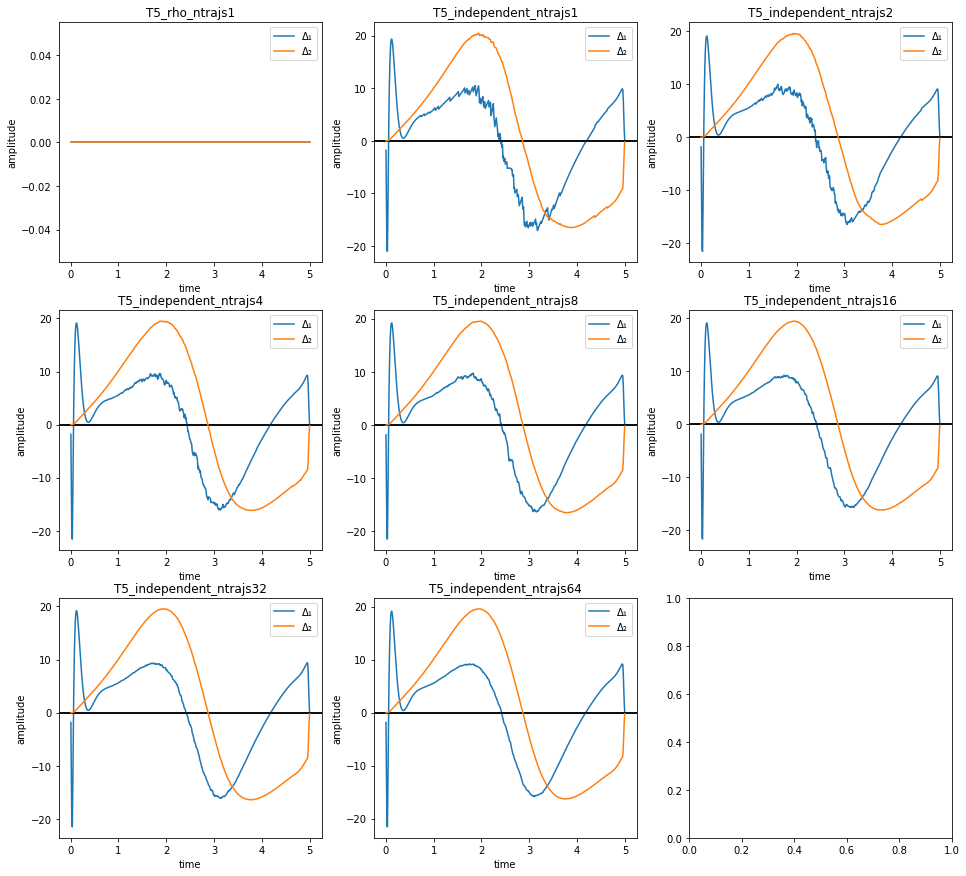

In [33]:
plot_pulse_delta([rf_rho, ] + rfs_independent_trajs)

How about comparing each pulse to a smoothed version of itself?

In [90]:
from scipy.signal import savgol_filter

In [96]:
def smooth_pulse_spline(pulse, **kwargs):
    return pulse.apply_smoothing(**kwargs)

In [97]:
def smooth_pulse_savgol(pulse, **kwargs):
    filtered = pulse.copy()
    ampl_filtered = savgol_filter(pulse.amplitude.real, **kwargs)
    filtered.amplitude = ampl_filtered
    return filtered

In [98]:
def plot_pulse_delta_smoothing(runfolders, smooth_pulse, **kwargs):
    """Plot pulses relative to smooth version of itself"""
    ncols = 3
    nrows = len(runfolders) // ncols
    if ncols * nrows < len(runfolders):
        nrows += 1
    fig, axs = plt.subplots(
        figsize=(16, nrows*5), ncols=ncols, nrows=nrows, squeeze=False)
    axs = axs.flatten()
    for i, rf in enumerate(runfolders):
        ax = axs[i]
        pulse1 = QDYN.pulse.Pulse.read(join(rf, 'pulse1.oct.dat'))
        pulse2 = QDYN.pulse.Pulse.read(join(rf, 'pulse2.oct.dat'))
        pulse1.amplitude -= smooth_pulse(pulse1, **kwargs).amplitude
        pulse2.amplitude -= smooth_pulse(pulse2, **kwargs).amplitude
        pulse1.render_pulse(ax, label=r'Δ₁')
        pulse2.render_pulse(ax, label=r'Δ₂')
        ax.legend()
        ax.set_xlabel("time")
        ax.set_ylabel("amplitude")
        ax.set_title(rf.split('/')[-1])
    plt.show(fig)

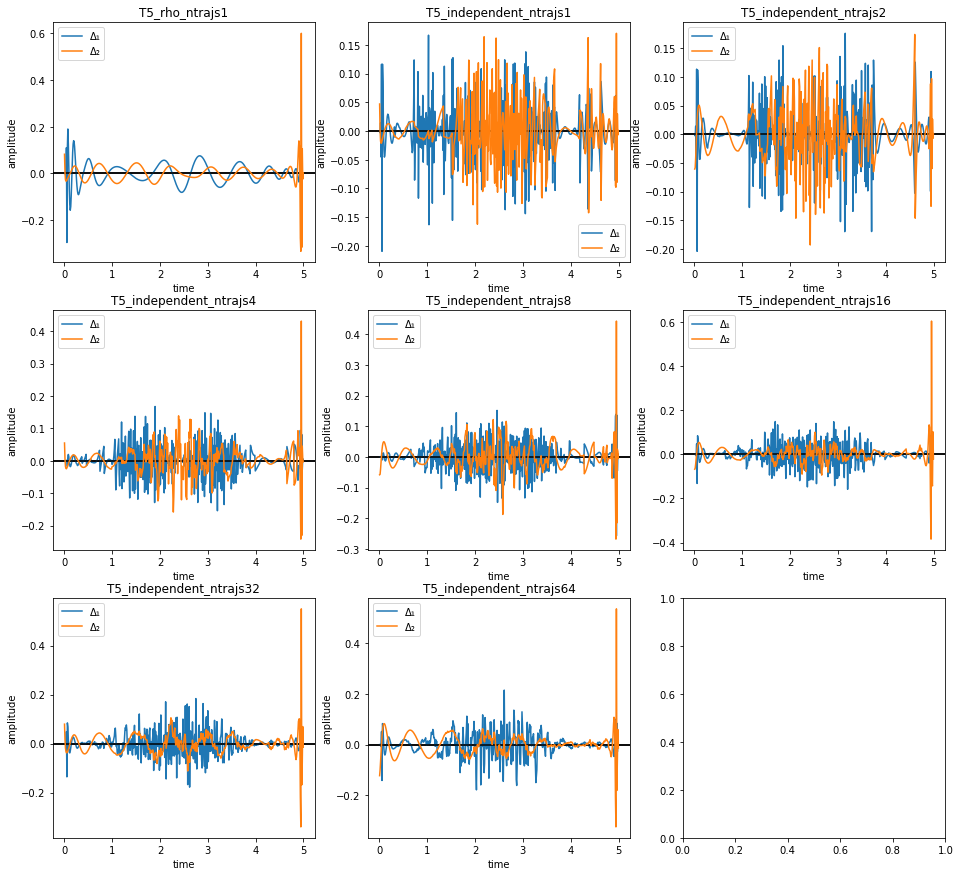

In [99]:
plot_pulse_delta_smoothing(
    [rf_rho, ] + rfs_independent_trajs,
    smooth_pulse_spline, s=1, k=5)

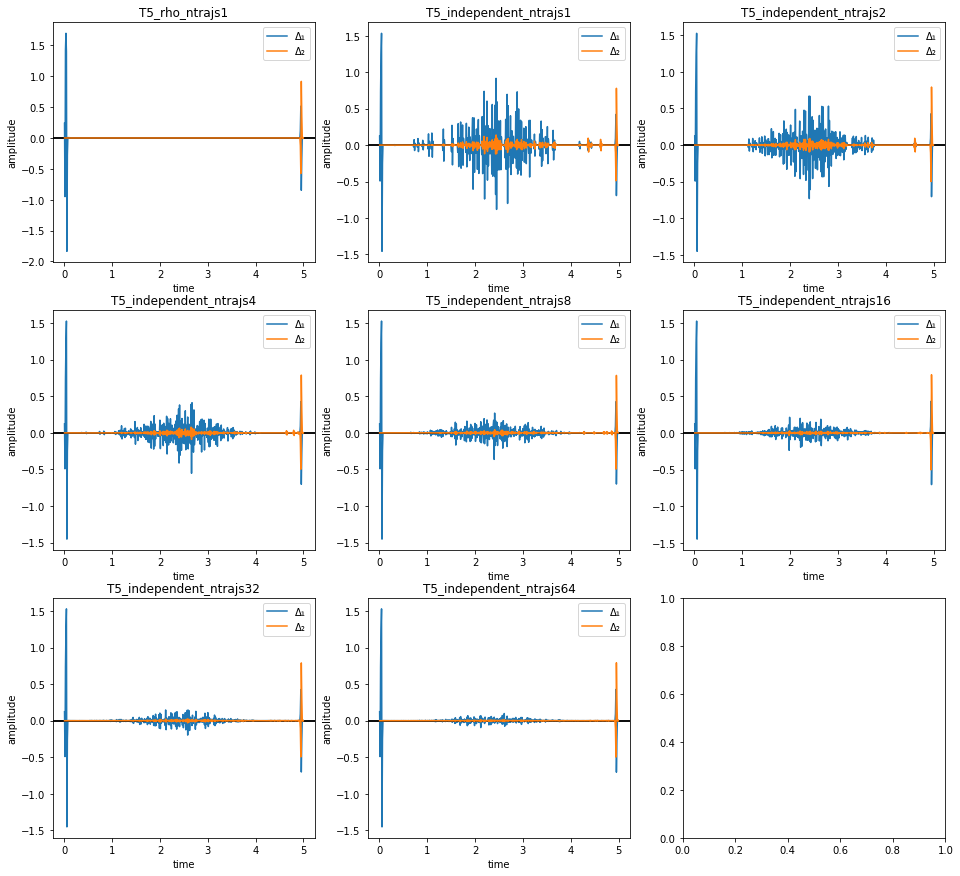

In [101]:
plot_pulse_delta_smoothing(
    [rf_rho, ] + rfs_independent_trajs,
    smooth_pulse_savgol,
    window_length=5, polyorder=3)

In [106]:
def collect_noise_table(runfolders, smooth_pulse, **kwargs):
    noise1 = [] # pulse 1
    noise2 = [] # pulse 2
    for rf in runfolders:
        pulse1 = QDYN.pulse.Pulse.read(join(rf, 'pulse1.oct.dat'))
        pulse2 = QDYN.pulse.Pulse.read(join(rf, 'pulse2.oct.dat'))
        pulse1.amplitude -= smooth_pulse(pulse1, **kwargs).amplitude
        pulse2.amplitude -= smooth_pulse(pulse2, **kwargs).amplitude
        dt = pulse1.tgrid[1] - pulse1.tgrid[0]
        pulse1_noise = sum(np.abs(pulse1.amplitude)) * dt
        pulse2_noise = sum(np.abs(pulse2.amplitude)) * dt
        noise1.append(pulse1_noise)
        noise2.append(pulse2_noise)
    return pd.DataFrame(
        data=OrderedDict([('ν1', noise1), ('ν2', noise2)]),
        index=runfolders)

In [108]:
noise_table = collect_noise_table(
    rfs_independent_trajs, smooth_pulse_savgol,
    window_length=5, polyorder=3)
noise_table

,ν1,ν2
./data/method_comparison_dicke/T5_independent_ntrajs1,0.487545,0.081669
./data/method_comparison_dicke/T5_independent_ntrajs2,0.406922,0.067747
./data/method_comparison_dicke/T5_independent_ntrajs4,0.307020,0.053664
./data/method_comparison_dicke/T5_independent_ntrajs8,0.223465,0.041236
./data/method_comparison_dicke/T5_independent_ntrajs16,0.187765,0.033990
./data/method_comparison_dicke/T5_independent_ntrajs32,0.164980,0.032128
./data/method_comparison_dicke/T5_independent_ntrajs64,0.125675,0.025942


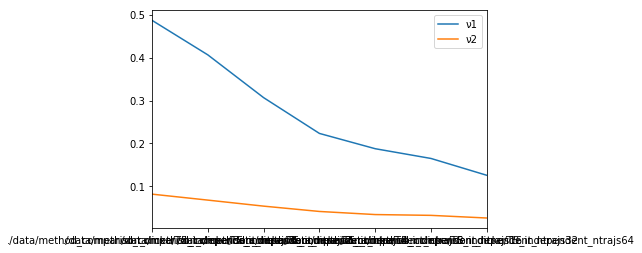

In [112]:
noise_table.plot()
plt.show()

#### XXX

In [58]:
pr = QDYN.pulse.Pulse.read(join(rf_rho, 'pulse1.oct.dat'))

In [59]:
p1 = QDYN.pulse.Pulse.read(join(rfs_independent_trajs[0], 'pulse1.oct.dat'))

In [60]:
def plot_spectrum(pulse):
    fig, ax = plt.subplots()
    pulse.render_spectrum(ax)
    ax.set_yscale('log')
    plt.show(fig)

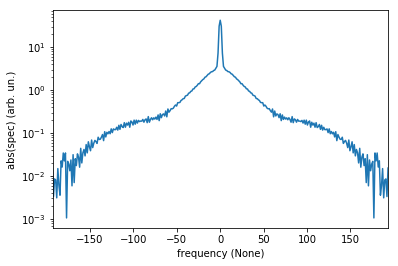

In [61]:
plot_spectrum(p1)

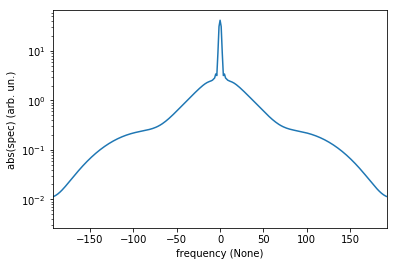

In [62]:
plot_spectrum(pr)

## How do the pulses compare between density matrix optimization and cross-referenced-trajectory optimization?

TODO (when I fix my screwup in that calculation). This is expected to increase the smoothness, and possibly improve convergence to be closer to that of the full density matrix optimization.